In [1]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from google.colab import drive
from IPython.display import HTML
from base64 import b64encode

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
print(os.getcwd())
os.chdir('/content/drive/MyDrive/capstone project')
print(os.getcwd())

/content/drive/MyDrive/capstone project/new_yolo
/content/drive/MyDrive/capstone project


In [4]:
def show_video(video_path, video_width=600):
    # Open and read the video file
    video_file = open(video_path, "rb").read()

    # Encode the video as base64
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"

    # Return the HTML to display the video with the specified width
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

# Example usage: show the video with a width of 400 pixels
show_video('john.mp4', video_width=200)

Output hidden; open in https://colab.research.google.com to view.

Calculating face Shape.....
(1920, 1080, 3)
Face detected at (x, y, w, h): 290 586 546 546


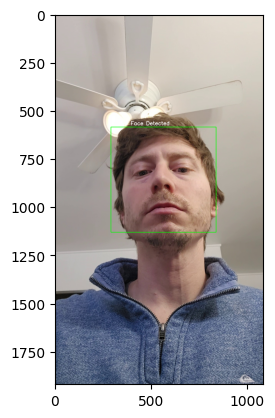

In [5]:
image_path = 'john/john_9.jpg'
img = cv2.imread(image_path)
print("Calculating face Shape.....")
print(img.shape)
image_height, image_width, _ = img.shape
# Load pre-trained Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Convert the image to grayscale (required for face detection)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
# Check if faces were detected
if len(faces) == 0:
    print("No face detected!")
# Get the first face detected (you can extend this for multiple faces)
x, y, w, h = faces[0]
#print("Face detected at (x, y, w, h):", x, y, x+w, y+h)
print("Face detected at (x, y, w, h):", x, y, w, h)
# Draw a rectangle around the face
cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
# Adjusting text position to ensure it's inside the image
text_position = (x, y - 10) if y - 10 > 0 else (x, y + h + 10)  # If too close to the top, move text down
# Add text above the bounding box
cv2.putText(img, "John's Face Detected", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
# Convert the image from BGR to RGB for displaying with Matplotlib
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Display the image with the bounding box using Matplotlib
plt.imshow(image_rgb)
#plt.axis('off')  # Hide axis for a cleaner view
plt.show()


In [6]:
import os
import cv2
import glob
import random
import shutil
import matplotlib.pyplot as plt

def detect_face_and_generate_yolo_format(image_path, output_txt_path, class_id=0):
    """
    Detects the first face in the image and writes a YOLO-format annotation to output_txt_path.

    YOLO format: <class_id> <x_center> <y_center> <width> <height>
    (all coordinates normalized to [0,1])
    """
    # Load Haar Cascade for face detection.
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Read the image.
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return False

    # Convert to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces.
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        print(f"No face detected in: {image_path}")
        return False

    # Use the first detected face.
    x, y, w, h = faces[0]

    # Get image dimensions.
    image_height, image_width, _ = img.shape

    # Calculate normalized center coordinates and box dimensions.
    x_center = (x + w / 2) / image_width
    y_center = (y + h / 2) / image_height
    norm_width = w / image_width
    norm_height = h / image_height

    # Create YOLO-format string.
    yolo_format = f"{class_id} {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}"

    # Write the annotation to the .txt file.
    with open(output_txt_path, 'w') as file:
        file.write(yolo_format)

    print(f"Annotation saved to {output_txt_path}")
    return True

def process_single_category_folder(main_folder, output_base, split_ratios={"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=0):
    """
    Processes a single category folder (e.g., "john") containing images.

    Splits the images into train/valid/test sets according to split_ratios,
    generates YOLO-format .txt annotation files for each image by detecting a face,
    and copies the images and annotation files into the corresponding output folders.

    The output folder structure will be:
      output_base/
         train/
            images/
            labels/
         valid/
            images/
            labels/
         test/
            images/
            labels/

    The annotation file for each image will have the same base filename as the image,
    with a .txt extension.
    """
    # List all .jpg images in the main folder.
    image_paths = glob.glob(os.path.join(main_folder, "*.jpg"))
    random.shuffle(image_paths)

    n = len(image_paths)
    n_train = int(n * split_ratios["train"])
    n_valid = int(n * split_ratios["valid"])
    n_test = n - n_train - n_valid  # Remaining images go to test.

    print(f"Processing folder '{main_folder}': Total images: {n} | Train: {n_train}, Valid: {n_valid}, Test: {n_test}")

    # Create the output folder structure.
    for split in split_ratios.keys():
        os.makedirs(os.path.join(output_base, split, "images"), exist_ok=True)
        os.makedirs(os.path.join(output_base, split, "labels"), exist_ok=True)

    # Split the images.
    train_images = image_paths[:n_train]
    valid_images = image_paths[n_train:n_train + n_valid]
    test_images = image_paths[n_train + n_valid:]

    # Function to process each list of images.
    def process_image_list(image_list, split):
        for image_path in image_list:
            filename = os.path.basename(image_path)
            # Destination path for the image.
            out_image_path = os.path.join(output_base, split, "images", filename)
            # The .txt file will have the same base name as the image.
            name_without_ext = os.path.splitext(filename)[0]
            out_txt_path = os.path.join(output_base, split, "labels", name_without_ext + ".txt")

            # Generate YOLO annotation.
            success = detect_face_and_generate_yolo_format(image_path, out_txt_path, class_id=class_id)
            if success:
                # Copy the image to the destination folder.
                shutil.copy(image_path, out_image_path)
            else:
                print(f"Skipping {image_path} due to face detection failure.")

    # Process each split.
    process_image_list(train_images, "train")
    process_image_list(valid_images, "valid")
    process_image_list(test_images, "test")

# Example usage:
# Pass in a single main folder (e.g., "john") and the desired output folder.
#process_single_category_folder("john", "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=0)

In [8]:
print(os.getcwd())
os.chdir('/content/drive/MyDrive/capstone project/new_yolo')
print(os.getcwd())

/content/drive/MyDrive/capstone project/new_yolo
/content/drive/MyDrive/capstone project/new_yolo


In [9]:
names = ["angela", "classmate", "giuliana", "javier", "john", "maite", "mike", "ron", "shanti", "tom", "vilma", "will"]

In [14]:
process_single_category_folder('/content/drive/MyDrive/capstone project/new_yolo/angela', "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=0)

Processing folder '/content/drive/MyDrive/capstone project/new_yolo/angela': Total images: 600 | Train: 420, Valid: 120, Test: 60
Annotation saved to my_data_split/train/labels/angela_new_129.txt
Annotation saved to my_data_split/train/labels/angela_new_425.txt
No face detected in: /content/drive/MyDrive/capstone project/new_yolo/angela/angela_new_334.jpg
Skipping /content/drive/MyDrive/capstone project/new_yolo/angela/angela_new_334.jpg due to face detection failure.
No face detected in: /content/drive/MyDrive/capstone project/new_yolo/angela/angela_new_259.jpg
Skipping /content/drive/MyDrive/capstone project/new_yolo/angela/angela_new_259.jpg due to face detection failure.
No face detected in: /content/drive/MyDrive/capstone project/new_yolo/angela/angela_new_550.jpg
Skipping /content/drive/MyDrive/capstone project/new_yolo/angela/angela_new_550.jpg due to face detection failure.
No face detected in: /content/drive/MyDrive/capstone project/new_yolo/angela/angela_new_182.jpg
Skipping 

In [15]:
process_single_category_folder('/content/drive/MyDrive/capstone project/new_yolo/classmate', "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=1)
process_single_category_folder('/content/drive/MyDrive/capstone project/new_yolo/giuliana', "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=2)
process_single_category_folder('/content/drive/MyDrive/capstone project/new_yolo/javier', "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=3)
process_single_category_folder('/content/drive/MyDrive/capstone project/new_yolo/john', "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=4)
process_single_category_folder('/content/drive/MyDrive/capstone project/new_yolo/maite', "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=5)
process_single_category_folder('/content/drive/MyDrive/capstone project/new_yolo/mike', "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=6)
process_single_category_folder('/content/drive/MyDrive/capstone project/new_yolo/ron', "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=7)
process_single_category_folder('/content/drive/MyDrive/capstone project/new_yolo/shanti', "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=8)
process_single_category_folder('/content/drive/MyDrive/capstone project/new_yolo/tom', "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=9)
process_single_category_folder('/content/drive/MyDrive/capstone project/new_yolo/vilma', "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=10)
process_single_category_folder('/content/drive/MyDrive/capstone project/new_yolo/will', "my_data_split", {"train": 0.7, "valid": 0.2, "test": 0.1}, class_id=11)


Streaming output truncated to the last 5000 lines.
Annotation saved to my_data_split/train/labels/mike_new_25.txt
Annotation saved to my_data_split/train/labels/mike_new_17.txt
Annotation saved to my_data_split/train/labels/mike_new_543.txt
Annotation saved to my_data_split/train/labels/mike_new_472.txt
Annotation saved to my_data_split/train/labels/mike_new_402.txt
Annotation saved to my_data_split/train/labels/mike_new_315.txt
Annotation saved to my_data_split/train/labels/mike_new_295.txt
Annotation saved to my_data_split/train/labels/mike_new_269.txt
Annotation saved to my_data_split/train/labels/mike_new_35.txt
Annotation saved to my_data_split/train/labels/mike_new_394.txt
Annotation saved to my_data_split/train/labels/mike_new_127.txt
Annotation saved to my_data_split/train/labels/mike_new_169.txt
Annotation saved to my_data_split/train/labels/mike_new_465.txt
Annotation saved to my_data_split/train/labels/mike_new_34.txt
Annotation saved to my_data_split/train/labels/mike_new_4